<a href="https://colab.research.google.com/github/himasha0421/Deep-Learning-For-Medical-Applications/blob/main/brain_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!mkdir .kaggle
import json
token = {"username":"himasha0421","key":"321ba73e9c1ee572038fd854d77da957"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 702M/714M [00:07<00:00, 86.1MB/s]
100% 714M/714M [00:07<00:00, 103MB/s] 


In [ ]:
!unzip /content/{/content}/datasets/mateuszbuda/lgg-mri-segmentation/lgg-mri-segmentation.zip 

In [ ]:

import os
import random

from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tqdm import tqdm
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave
from skimage.transform import resize, rescale, rotate
from torch.utils.data import Dataset
from torchvision.transforms import Compose

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
def crop_sample(x):
    volume, mask = x
    volume[volume < np.max(volume) * 0.1] = 0
    z_projection = np.max(np.max(np.max(volume, axis=-1), axis=-1), axis=-1)
    z_nonzero = np.nonzero(z_projection)
    z_min = np.min(z_nonzero)
    z_max = np.max(z_nonzero) + 1
    y_projection = np.max(np.max(np.max(volume, axis=0), axis=-1), axis=-1)
    y_nonzero = np.nonzero(y_projection)
    y_min = np.min(y_nonzero)
    y_max = np.max(y_nonzero) + 1
    x_projection = np.max(np.max(np.max(volume, axis=0), axis=0), axis=-1)
    x_nonzero = np.nonzero(x_projection)
    x_min = np.min(x_nonzero)
    x_max = np.max(x_nonzero) + 1
    return (
        volume[z_min:z_max, y_min:y_max, x_min:x_max],
        mask[z_min:z_max, y_min:y_max, x_min:x_max],
    )


def pad_sample(x):
    volume, mask = x
    a = volume.shape[1]
    b = volume.shape[2]
    if a == b:
        return volume, mask
    diff = (max(a, b) - min(a, b)) / 2.0
    if a > b:
        padding = ((0, 0), (0, 0), (int(np.floor(diff)), int(np.ceil(diff))))
    else:
        padding = ((0, 0), (int(np.floor(diff)), int(np.ceil(diff))), (0, 0))
    mask = np.pad(mask, padding, mode="constant", constant_values=0)
    padding = padding + ((0, 0),)
    volume = np.pad(volume, padding, mode="constant", constant_values=0)
    return volume, mask


def resize_sample(x, size=256):
    volume, mask = x
    v_shape = volume.shape
    out_shape = (v_shape[0], size, size)
    mask = resize(
        mask,
        output_shape=out_shape,
        order=0,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    )
    out_shape = out_shape + (v_shape[3],)
    volume = resize(
        volume,
        output_shape=out_shape,
        order=2,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    )
    return volume, mask


def normalize_volume(volume):
    p10 = np.percentile(volume, 10)
    p99 = np.percentile(volume, 99)
    volume = rescale_intensity(volume, in_range=(p10, p99))
    m = np.mean(volume, axis=(0, 1, 2))
    s = np.std(volume, axis=(0, 1, 2))
    volume = (volume - m) / s
    return volume
#*************************************** Dataset class **************************************************************************************8

class BrainSegmentationDataset(Dataset):
    """Brain MRI dataset for FLAIR abnormality segmentation"""

    in_channels = 3
    out_channels = 1

    def __init__(
        self,
        images_dir,
        transform=None,
        image_size=256,
        subset="train",
        random_sampling=True,
        seed=42,
    ):
        assert subset in ["all", "train", "validation"]

        # read images
        volumes = {}
        masks = {}
        print("reading {} images...".format(subset))
        for (dirpath, dirnames, filenames) in os.walk(images_dir):
            image_slices = []
            mask_slices = []
            for filename in sorted(
                filter(lambda f: ".tif" in f, filenames),
                key=lambda x: int(x.split(".")[-2].split("_")[4]),
            ):
                filepath = os.path.join(dirpath, filename)
                if "mask" in filename:
                    mask_slices.append(imread(filepath, as_gray=True))
                else:
                    image_slices.append(imread(filepath))
            if len(image_slices) > 0:
                patient_id = dirpath.split("/")[-1]
                volumes[patient_id] = np.array(image_slices[1:-1])
                masks[patient_id] = np.array(mask_slices[1:-1])

        self.patients = sorted(volumes)

        # select cases to subset
        if not subset == "all":
            random.seed(seed)
            validation_patients = random.sample(self.patients, k=10)
            if subset == "validation":
                self.patients = validation_patients
            else:
                self.patients = sorted(
                    list(set(self.patients).difference(validation_patients))
                )

        print("preprocessing {} volumes...".format(subset))
        # create list of tuples (volume, mask)
        self.volumes = [(volumes[k], masks[k]) for k in self.patients]

        print("cropping {} volumes...".format(subset))
        # crop to smallest enclosing volume
        self.volumes = [crop_sample(v) for v in self.volumes]

        print("padding {} volumes...".format(subset))
        # pad to square
        self.volumes = [pad_sample(v) for v in self.volumes]

        print("resizing {} volumes...".format(subset))
        # resize
        self.volumes = [resize_sample(v, size=image_size) for v in self.volumes]

        print("normalizing {} volumes...".format(subset))
        # normalize channel-wise
        self.volumes = [(normalize_volume(v), m) for v, m in self.volumes]

        # probabilities for sampling slices based on masks
        self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v, m in self.volumes]
        self.slice_weights = [
            (s + (s.sum() * 0.1 / len(s))) / (s.sum() * 1.1) for s in self.slice_weights
        ]

        # add channel dimension to masks
        self.volumes = [(v, m[..., np.newaxis]) for (v, m) in self.volumes]

        print("done creating {} dataset".format(subset))

        # create global index for patient and slice (idx -> (p_idx, s_idx))
        num_slices = [v.shape[0] for v, m in self.volumes]
        self.patient_slice_index = list(
            zip(
                sum([[i] * num_slices[i] for i in range(len(num_slices))], []),
                sum([list(range(x)) for x in num_slices], []),
            )
        )

        self.random_sampling = random_sampling

        self.transform = transform

    def __len__(self):
        return len(self.patient_slice_index)

    def __getitem__(self, idx):
        patient = self.patient_slice_index[idx][0]
        slice_n = self.patient_slice_index[idx][1]

        if self.random_sampling:
            patient = np.random.randint(len(self.volumes))
            slice_n = np.random.choice(
                range(self.volumes[patient][0].shape[0]), p=self.slice_weights[patient]
            )

        v, m = self.volumes[patient]
        image = v[slice_n]
        mask = m[slice_n]

        if self.transform is not None:
            image, mask = self.transform((image, mask))

        # fix dimensions (C, H, W)
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))

        # return tensors
        return image_tensor, mask_tensor
    
#******************************************** Dataset transforms *********************************************************************************88

def transforms(scale=None, angle=None, flip_prob=None):
    transform_list = []

    if scale is not None:
        transform_list.append(Scale(scale))
    if angle is not None:
        transform_list.append(Rotate(angle))
    if flip_prob is not None:
        transform_list.append(HorizontalFlip(flip_prob))

    return Compose(transform_list)


class Scale(object):

    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        image, mask = sample

        img_size = image.shape[0]

        scale = np.random.uniform(low=1.0 - self.scale, high=1.0 + self.scale)

        image = rescale(
            image,
            (scale, scale),
            multichannel=True,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        )
        mask = rescale(
            mask,
            (scale, scale),
            order=0,
            multichannel=True,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        )

        if scale < 1.0:
            #if scale is velow 1.0 then pad the image to have same input shape otherwise nurel network results may inconsistent
            diff = (img_size - image.shape[0]) / 2.0
            padding = ((int(np.floor(diff)), int(np.ceil(diff))),) * 2 + ((0, 0),)
            image = np.pad(image, padding, mode="constant", constant_values=0)
            mask = np.pad(mask, padding, mode="constant", constant_values=0)
        else:
            # if scale is larger than 1.0 then take the original size from that image
            x_min = (image.shape[0] - img_size) // 2
            x_max = x_min + img_size
            image = image[x_min:x_max, x_min:x_max, ...]
            mask = mask[x_min:x_max, x_min:x_max, ...]

        return image, mask


class Rotate(object):

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, sample):
        image, mask = sample

        angle = np.random.uniform(low=-self.angle, high=self.angle)
        image = rotate(image, angle, resize=False, preserve_range=True, mode="constant")
        mask = rotate(
            mask, angle, resize=False, order=0, preserve_range=True, mode="constant"
        )
        return image, mask


class HorizontalFlip(object):

    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, sample):
        image, mask = sample

        if np.random.rand() > self.flip_prob:
            return image, mask

        image = np.fliplr(image).copy()
        mask = np.fliplr(mask).copy()

        return image, mask

# *********************************************** define data loaders *********************************8
    
def data_loaders(batch_size, workers, image_size, aug_scale, aug_angle):
    dataset_train, dataset_valid = datasets("/content/lgg-mri-segmentation/kaggle_3m", image_size, aug_scale, aug_angle)

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=workers,
        worker_init_fn=worker_init,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        drop_last=False,
        num_workers=workers,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid


def datasets(images, image_size, aug_scale, aug_angle):
    train = BrainSegmentationDataset(
        images_dir=images,
        subset="train",
        image_size=image_size,
        transform=transforms(scale=aug_scale, angle=aug_angle, flip_prob=0.5),
    )
    valid = BrainSegmentationDataset(
        images_dir=images,
        subset="validation",
        image_size=image_size,
        random_sampling=False,
    )
    return train, valid




batch_size = 16
epochs = 10
lr = 0.0001
workers = 2
weights ="/content/gdrive/My Drive/models"
image_size = 224
aug_scale = 0.05
aug_angle = 15

# Visualization

In [ ]:
def outline(image, mask, color):
    mask = np.round(mask)
    yy, xx = np.nonzero(mask)
    for y, x in zip(yy, xx):
        if 0.0 < np.mean(mask[max(0, y - 1) : y + 2, max(0, x - 1) : x + 2]) < 1.0:
            image[max(0, y) : y + 1, max(0, x) : x + 1] = color
    return image

def log_images(x, y_true, y_pred, channel=1):
    images = []
    x_np = x[:, channel].cpu().numpy()
    y_true_np = y_true[:, 0].cpu().numpy()
    y_pred_np = y_pred[:, 0].cpu().numpy()
    for i in range(x_np.shape[0]):
        image = gray2rgb(np.squeeze(x_np[i]))
        image = outline(image, y_pred_np[i], color=[255, 0, 0])
        image = outline(image, y_true_np[i], color=[0, 255, 0])
        images.append(image)
    return images


def gray2rgb(image):
    w, h = image.shape
    image += np.abs(np.min(image))
    image_max = np.abs(np.max(image))
    if image_max > 0:
        image /= image_max
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 2] = ret[:, :, 1] = ret[:, :, 0] = image * 255
    return ret

In [ ]:
import random
def viz_images(image , mask):
    img_max = image.max().numpy()
    img_min = image.min().numpy()
    image = image.numpy()
    mask  = mask.numpy()
    image = np.transpose(image , (1,2,0))
    image = (image-img_min)/(img_max - img_min)
    mask = np.transpose(mask , (1,2,0)).squeeze(2)
    img_copy = np.copy(image)
    mask_copy = np.copy(mask)
    outline_img = outline(img_copy , mask_copy , (1,0,0))
    
    return image , mask , outline_img

"""
fig = plt.figure(figsize=(15, 15))
n_cols =3
n_rows =4
sample_list = list(range(len(image_train)))
for i  in range(4):
    idx = np.random.choice(sample_list)
    image , mask , outline_image = viz_images(image_train[idx], mask_train[idx])
    ax1 = fig.add_subplot(n_rows, n_cols, n_cols * i + 1)
    ax2 = fig.add_subplot(n_rows, n_cols, n_cols * i + 2)
    ax3 = fig.add_subplot(n_rows, n_cols, n_cols * i + 3)
    ax1.imshow(image)
    ax1.set_title("Original Image")
    ax2.imshow(mask)
    ax2.set_title("Mask Image")
    ax3.imshow(outline_image)
    ax3.set_title("Outline Image")
plt.show()
"""

'\nfig = plt.figure(figsize=(15, 15))\nn_cols =3\nn_rows =4\nsample_list = list(range(len(image_train)))\nfor i  in range(4):\n    idx = np.random.choice(sample_list)\n    image , mask , outline_image = viz_images(image_train[idx], mask_train[idx])\n    ax1 = fig.add_subplot(n_rows, n_cols, n_cols * i + 1)\n    ax2 = fig.add_subplot(n_rows, n_cols, n_cols * i + 2)\n    ax3 = fig.add_subplot(n_rows, n_cols, n_cols * i + 3)\n    ax1.imshow(image)\n    ax1.set_title("Original Image")\n    ax2.imshow(mask)\n    ax2.set_title("Mask Image")\n    ax3.imshow(outline_image)\n    ax3.set_title("Outline Image")\nplt.show()\n'

In [ ]:
def deconv(in_channels , out_channels  , kernel_size=4 , strides=2 , padding = 1 ,dilation=1 , bathc_norm=True , activation=True):
    filters=[]
    conv_trans = nn.ConvTranspose2d(in_channels , out_channels ,
                                    kernel_size=kernel_size , stride=strides , padding=padding  ,dilation=dilation , bias=False)
    filters.append(conv_trans)
    if(bathc_norm):
        bn = nn.BatchNorm2d(out_channels)
        filters.append(bn)
    if(activation):
        activ = nn.ReLU(inplace=True)
        filters.append(activ)
        
    return nn.Sequential(*filters)

In [ ]:
def conv(in_channels , out_channels , kernel_size , strides , padding , batch_norm=True , activation=True):
    filters=[]
    conv = nn.Conv2d(in_channels=in_channels , out_channels=out_channels , kernel_size=kernel_size , stride=strides , padding=padding , bias=False)
    filters.append(conv)
    if(batch_norm):
        bn = nn.BatchNorm2d(num_features=out_channels)
        filters.append(bn)
    if(activation):
        activ = nn.ReLU(inplace=True)
        filters.append(activ)
        
    return nn.Sequential(*filters)

In [ ]:
def resblock(in_channels , out_channels , kernel_size , strides , padding , batch_norm=True):
    filters=[]
    conv_block1 = conv(in_channels=in_channels , out_channels=out_channels ,
                       kernel_size=kernel_size , strides=strides ,
                       padding=padding , batch_norm=batch_norm)
    filters.append(conv_block1)
    conv_block2 = conv(in_channels=out_channels , out_channels=out_channels ,
                       kernel_size=kernel_size , strides=strides ,
                       padding=padding , batch_norm=batch_norm)
    filters.append(conv_block2)
    
    return nn.Sequential(*filters)

In [ ]:
from torchvision import models
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        features = 32
        vgg_19 = models.vgg19_bn(pretrained=False)
        vgg_module = list(vgg_19.children())[:-2]

        layer_indx = [6 , 13 , 26 , 39 , 52]

        self.vgg_block1 =  vgg_module[0][:7]                                 # 3 --> 64  (2,2) downsample
        self.vgg_block2 =  vgg_module[0][7:14]                               #64 -->128  (2,2) downsample
        self.vgg_block3 =  vgg_module[0][14:27]                              #128 -->256 (2,2) downsample
        self.vgg_block4 =  vgg_module[0][27:40]                              #256 --> 512 (2,2) downsample
        self.vgg_block5 =  vgg_module[0][40:53]                              # 512 --> 1024 (2,2) dwonsample
        self.conv_vgg_out = UNet._conv(512 , 1024 , kernel_size=3 , strides=1 , padding=1)
        
        self.res_block1 = UNet._resblock(1024 , 1024 ,kernel_size=3 , strides=1 , padding=1)
        self.res_block2 = UNet._resblock(1024 , 1024 ,kernel_size=3 , strides=1 , padding=1)
        self.res_block3 = UNet._resblock(1024 , 1024 ,kernel_size=3 , strides=1 , padding=1)
        
        self.fpn_5 = UNet._deconv(features*32 , features , kernel_size=8 , strides=32 , padding = 2 ,dilation=5 ,  bathc_norm=True , activation=True)
        
        self.upconv4 = UNet._deconv(features * 32 , features * 16)
        self.decoder4 = UNet._conv((features * 16) * 2, features * 16, kernel_size=3 , strides=1 , padding=1 )
        self.fpn_4 = UNet._deconv (features*16 , features , kernel_size=6 , strides=16 , padding = 0 ,dilation=3 ,  bathc_norm=True , activation=True)
        
        self.upconv3 = UNet._deconv(features * 16, features * 8)
        self.decoder3 = UNet._conv((features * 8) * 2, features * 8, kernel_size=3 , strides=1 , padding=1)
        self.fpn_3 = UNet._deconv (features*8 , features , kernel_size=4 , strides=8 , padding = 1 ,dilation=3 ,  bathc_norm=True , activation=True)
        
        self.upconv2 = UNet._deconv(features * 8, features * 4)
        self.decoder2 = UNet._conv((features * 4) * 2, features * 4, kernel_size=3 , strides=1 , padding=1)
        self.fpn_2 = UNet._deconv (features*4 , features , kernel_size=4 , strides=4 , padding = 0 ,dilation=1 ,  bathc_norm=True , activation=True)
        
        self.upconv1 = UNet._deconv(features * 4, features*2)
        self.decoder1 = UNet._conv((features * 2)*2 , features *2, kernel_size=3 , strides=1 , padding=1)
        self.fpn_1 = UNet._deconv (features*2 , features , kernel_size=4 , strides=2 , padding = 1 ,dilation=1 ,  bathc_norm=True , activation=True)
        
        self.upconv0 = UNet._deconv(features * 2 , features)
        
        
        self.conv = UNet._conv(
            in_channels=features*6, out_channels=out_channels, kernel_size=1 ,strides=1 ,  padding=0 , batch_norm=False , activation=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        enc1 = self.vgg_block1(x)
        enc2 = self.vgg_block2(enc1)
        enc3 = self.vgg_block3(enc2)
        enc4 = self.vgg_block4(enc3)
        enc5 = self.vgg_block5(enc4)
        enc_out = self.conv_vgg_out(enc5)
        
        res1 = self.res_block1(enc_out)
        res2_in = res1 + enc_out
        res2 = self.res_block2(res2_in)
        res3_in = res2 + res2_in
        res3 = self.res_block3(res3_in)
        dec_in = res3 + res3_in
        
        fpn_5 = self.fpn_5(dec_in)
        
        dec5 = self.upconv4(dec_in)
        dec5 = torch.cat((dec5, enc4), dim=1)
        dec4 = self.decoder4(dec5)
        
        fpn_4 = self.fpn_4(dec4)
        
        dec4 = self.upconv3(dec4)
        dec3 = torch.cat((dec4, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        fpn_3 = self.fpn_3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.decoder2(dec2)
        
        fpn_2 = self.fpn_2(dec1)
        
        dec1 = self.upconv1(dec1)
        dec0 = torch.cat((dec1, enc1), dim=1)        
        dec_out = self.decoder1(dec0)
        
        fpn_1 = self.fpn_1(dec_out)
                  
        out = self.upconv0(dec_out)
        dec0 = torch.cat((out ,fpn_1 ,fpn_2 , fpn_3 , fpn_4 , fpn_5 ), dim=1) 
        
        return self.sigmoid(self.conv(dec0))
    
    @staticmethod
    def _deconv(in_channels , out_channels  , kernel_size=4 , strides=2 , padding = 1 ,dilation=1 , bathc_norm=True , activation=True):
        filters=[]
        conv_trans = nn.ConvTranspose2d(in_channels , out_channels ,
                                        kernel_size=kernel_size , stride=strides , padding=padding  ,dilation=dilation , bias=True)
        filters.append(conv_trans)
        if(bathc_norm):
            bn = nn.BatchNorm2d(out_channels)
            filters.append(bn)
        if(activation):
            activ = nn.ReLU(inplace=True)
            filters.append(activ)

        return nn.Sequential(*filters)
    
    @staticmethod
    def _conv(in_channels , out_channels , kernel_size , strides , padding , batch_norm=True , activation=True):
        filters=[]
        conv = nn.Conv2d(in_channels=in_channels , out_channels=out_channels , kernel_size=kernel_size , stride=strides , padding=padding , bias=True)
        filters.append(conv)
        if(batch_norm):
            bn = nn.BatchNorm2d(num_features=out_channels)
            filters.append(bn)
        if(activation):
            activ = nn.ReLU(inplace=True)
            filters.append(activ)

        return nn.Sequential(*filters)
    
    @staticmethod
    def _resblock(in_channels , out_channels , kernel_size , strides , padding , batch_norm=True):
        filters=[]
        conv_block1 = UNet._conv(in_channels=in_channels , out_channels=out_channels ,
                           kernel_size=kernel_size , strides=strides ,
                           padding=padding , batch_norm=batch_norm)
        filters.append(conv_block1)
        conv_block2 = UNet._conv(in_channels=out_channels , out_channels=out_channels ,
                           kernel_size=kernel_size , strides=strides ,
                           padding=padding , batch_norm=batch_norm)
        filters.append(conv_block2)

        return nn.Sequential(*filters)
    

  

In [ ]:
import torch
def weight_init(m):
    if(type(m) == nn.Conv2d):
        torch.nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0)

In [ ]:
# define the IOU loss function for medical image segementation
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc
    
def log_loss_summary(loss, step, prefix=""):
    print("epoch {} | {}: {}".format(step + 1, prefix + "loss", np.mean(loss)))

def log_scalar_summary(tag, value, step):
    print("epoch {} | {}: {}".format(step + 1, tag, value))

In [ ]:
def dsc(y_pred, y_true):
    y_pred = np.round(y_pred).astype(int)
    y_true = np.round(y_true).astype(int)
    return np.sum(y_pred[y_true == 1]) * 2.0 / (np.sum(y_pred) + np.sum(y_true))


def dsc_distribution(volumes):
    dsc_dict = {}
    for p in volumes:
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        dsc_dict[p] = dsc(y_pred, y_true)
    return dsc_dict


def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list


def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes


def plot_dsc(dsc_dist):
    y_positions = np.arange(len(dsc_dist))
    dsc_dist = sorted(dsc_dist.items(), key=lambda x: x[1])
    values = [x[1] for x in dsc_dist]
    labels = [x[0] for x in dsc_dist]
    labels = ["_".join(l.split("_")[1:-1]) for l in labels]
    fig = plt.figure(figsize=(12, 8))
    canvas = FigureCanvasAgg(fig)
    plt.barh(y_positions, values, align="center", color="skyblue")
    plt.yticks(y_positions, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.1))
    plt.xlim([0.0, 1.0])
    plt.gca().axvline(np.mean(values), color="tomato", linewidth=2)
    plt.gca().axvline(np.median(values), color="forestgreen", linewidth=2)
    plt.xlabel("Dice coefficient", fontsize="x-large")
    plt.gca().xaxis.grid(color="silver", alpha=0.5, linestyle="--", linewidth=1)
    plt.tight_layout()
    canvas.draw()
    plt.close()
    s, (width, height) = canvas.print_to_buffer()
    return np.fromstring(s, np.uint8).reshape((height, width, 4))

In [ ]:
loader_train, loader_valid = data_loaders(batch_size, workers, image_size, aug_scale, aug_angle)
loaders = {"train": loader_train, "valid": loader_valid}

reading train images...
preprocessing train volumes...
cropping train volumes...
padding train volumes...
resizing train volumes...
normalizing train volumes...
done creating train dataset
reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


In [ ]:
def train_validate():
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    
    unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
    unet.to(device)
    
    dsc_loss = DiceLoss()
    best_validation_dsc = 0.0
    
    optimizer = optim.Adam(unet.parameters(), lr=lr)
    
    loss_train = []
    loss_valid = []
    
    step = 0
    
    for epoch in range(epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()
    
            validation_pred = []
            validation_true = []
    
            for i, data in enumerate(loaders[phase]):
                if phase == "train":
                    step += 1
    
                x, y_true = data
                x, y_true = x.to(device), y_true.to(device)
    
                optimizer.zero_grad()
    
                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)
                    #compute the iou loss ( else we can use the BCELoss but don't use both)
                    loss = dsc_loss(y_pred, y_true)
    
                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
    
            if phase == "train":
                log_loss_summary(loss_train, epoch)
                loss_train = []

            if phase == "valid":
                log_loss_summary(loss_valid, epoch, prefix="val_")
                mean_dsc = np.mean(
                    dsc_per_volume(
                        validation_pred,
                        validation_true,
                        loader_valid.dataset.patient_slice_index,
                    )
                )
                log_scalar_summary("val_dsc", mean_dsc, epoch)
                if mean_dsc > best_validation_dsc:
                    best_validation_dsc = mean_dsc
                    torch.save(unet.state_dict(), os.path.join(weights, "unet.pt"))
                loss_valid = []
    
    print("\nBest validation mean DSC: {:4f}\n".format(best_validation_dsc))
    
    state_dict = torch.load(os.path.join(weights, "unet.pt"))
    unet.load_state_dict(state_dict)
    unet.eval()
    
    input_list = []
    pred_list = []
    true_list = []
    
    for i, data in enumerate(loader_valid):
        x, y_true = data
        x, y_true = x.to(device), y_true.to(device)
        with torch.set_grad_enabled(False):
            y_pred = unet(x)
            y_pred_np = y_pred.detach().cpu().numpy()
            pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
            y_true_np = y_true.detach().cpu().numpy()
            true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
            x_np = x.detach().cpu().numpy()
            input_list.extend([x_np[s] for s in range(x_np.shape[0])])
            
    volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
        loader_valid.dataset.patients,
    )
    
    dsc_dist = dsc_distribution(volumes)

    dsc_dist_plot = plot_dsc(dsc_dist)
    imsave("./dsc.png", dsc_dist_plot)

    for p in volumes:
        x = volumes[p][0]
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        for s in range(x.shape[0]):
            image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
            image = outline(image, y_pred[s, 0], color=[255, 0, 0])
            image = outline(image, y_true[s, 0], color=[0, 255, 0])
            filename = "{}-{}.png".format(p, str(s).zfill(2))
            filepath = os.path.join("./", filename)
            imsave(filepath, image)


train_validate()

epoch 1 | loss: 0.6660098674205633
epoch 1 | val_loss: 0.8247868106478736
epoch 1 | val_dsc: 0.3106556374488428
epoch 2 | loss: 0.3730280319085488
epoch 2 | val_loss: 0.6186045010884603
epoch 2 | val_dsc: 0.7710118680263041
epoch 3 | loss: 0.220110728763617
epoch 3 | val_loss: 0.4922363105274382
epoch 3 | val_dsc: 0.8007566436010201
epoch 4 | loss: 0.15595722399078882
epoch 4 | val_loss: 0.4306360085805257
epoch 4 | val_dsc: 0.8323484575274355
epoch 5 | loss: 0.1276533119380474
epoch 5 | val_loss: 0.40969323828106835
epoch 5 | val_dsc: 0.8340915741811724
epoch 6 | loss: 0.11767664981576112
epoch 6 | val_loss: 0.39364549659547354
epoch 6 | val_dsc: 0.8204928275920567
epoch 7 | loss: 0.10899810005839054
epoch 7 | val_loss: 0.4078612668173654
epoch 7 | val_dsc: 0.7867628768651604
epoch 8 | loss: 0.09560541923229511
epoch 8 | val_loss: 0.3681647777557373
epoch 8 | val_dsc: 0.8158172020638566
epoch 9 | loss: 0.08844290902981392
epoch 9 | val_loss: 0.3751566097849891
epoch 9 | val_dsc: 0.821

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: UserWarning: ./TCGA_DU_7014_19860618-57.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: UserWarning: ./TCGA_DU_6408_19860521-51.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: UserWarning: ./TCGA_DU_6408_19860521-52.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: UserWarning: ./TCGA_DU_6408_19860521-53.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: UserWarning: ./TCGA_DU_6404_19850629-50.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: UserWarning: ./TCGA_DU_5851_19950428-34.png is a low contrast ima

In [ ]:
import os
files = os.listdir('/content')

In [ ]:
img_files=[]
for file in files :
    val = file.endswith(".png")
    if(val):
        img_files.append(file)

In [ ]:
split_idx = 0.06
viz_content = int(split_idx * len(img_files))
print(viz_content)

19


Red --> Model segmentation                                   Green --> Ground truth segmentation 


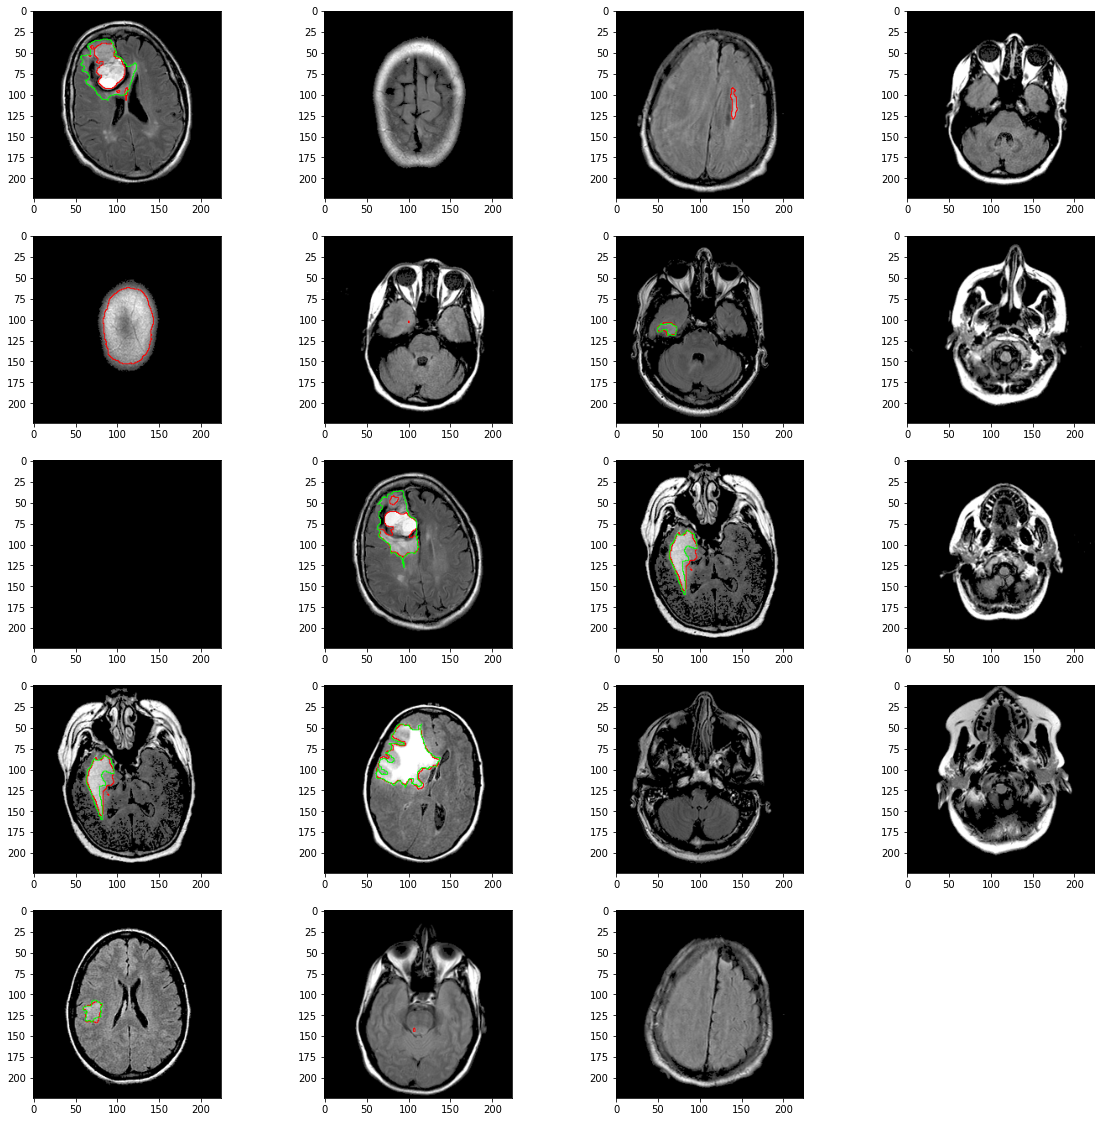

In [ ]:
import cv2
split_idx = 0.06
viz_content = int(split_idx * len(img_files))
idx_list = np.arange(len(img_files))
print("Red --> Model segmentation                                   Green --> Ground truth segmentation ")
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for index in range(viz_content):
    img_index = np.random.choice(idx_list)
    img_bgr = cv2.imread(img_files[img_index])
    img_rgb = cv2.cvtColor(img_bgr , cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, index+1)
    plt.imshow(img_rgb)
